In [ ]:
from src.sampling.images import plot_frame_count_distributions

samples_root_dir = "data/samples"

plot_frame_count_distributions(samples_root_dir)

# Sota K-Fold cross validation

Building fold 1 ...
Fold 1: Train size = 4395, Val size = 546, Test size = 549
starting run #0
loading a fresh model 'yolo11m-cls'


wandb: Currently logged in as: tom-decoutere (tom-decoutere-open-universiteit) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


New https://pypi.org/project/ultralytics/8.3.171 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
engine/trainer: task=classify, mode=train, model=yolo11m-cls.pt, data=data/img/techniques_kf/current_fold, epochs=1, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=data/runs/sota/yolo11m-cls-fold1, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina

E0000 00:00:1754032214.091189   42430 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754032214.453476   42430 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Overriding model.yaml nc=80 with nc=7

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    111872  ultralytics.nn.modules.block.C3k2            [128, 256, 1, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  1    444928  ultralytics.nn.modules.block.C3k2            [256, 512, 1, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  1   1380352  ultralytics.nn.modules.block.C3k2            [512, 512, 1, True]           
  7                  -1  1   2360320  ultralytics

train: Scanning /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/train... 4395 images, 0 corrupt: 100%|██████████| 4395/4395 [01:15<00:00, 57.93it/s] 


train: New cache created: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/train.cache


val: Scanning /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val... 546 images, 0 corrupt: 100%|██████████| 546/546 [00:10<00:00, 51.12it/s] 


val: New cache created: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val.cache
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 49 weight(decay=0.0), 50 weight(decay=0.0005), 50 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to data/runs/sota/yolo11m-cls-fold1/train
Starting training for 1 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:05<00:00,  3.53it/s]


                   all      0.705      0.985


Generating Visualizations for batch-1/1:   0%|          | 0/1 [00:00<?, ?it/s]

Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
YOLO11m-cls summary (fused): 57 layers, 11,622,632 parameters, 0 gradients, 40.3 GFLOPs


Generating Visualizations for batch-1/1: 100%|██████████| 1/1 [00:00<00:00, 193.51it/s]



1 epochs completed in 0.027 hours.
Optimizer stripped from data/runs/sota/yolo11m-cls-fold1/train/weights/last.pt, 20.9MB
Optimizer stripped from data/runs/sota/yolo11m-cls-fold1/train/weights/best.pt, 20.9MB

Validating data/runs/sota/yolo11m-cls-fold1/train/weights/best.pt...
Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
YOLO11m-cls summary (fused): 57 layers, 10,350,599 parameters, 0 gradients, 39.3 GFLOPs
train: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/train... found 4395 images in 7 classes ✅ 
val: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val... found 546 images in 7 classes ✅ 
test: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/test... found 549 images in 7 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:04<00:00,  4.16it/s]


                   all      0.712      0.989


Generating Visualizations for batch-1/1: 100%|██████████| 1/1 [00:00<00:00, 172.10it/s]

Speed: 0.4ms preprocess, 2.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to data/runs/sota/yolo11m-cls-fold1/train


lr/pg0,▁
lr/pg1,▁
lr/pg2,▁
metrics/accuracy_top1,▁
metrics/accuracy_top5,▁
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/loss,▁
val/loss,▁
lr/pg0,0.0003


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f20b545cfe0>
curves: []
curves_results: []
fitness: 0.8507325947284698
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.7124541997909546, 'metrics/accuracy_top5': 0.9890109896659851, 'fitness': 0.8507325947284698}
save_dir: PosixPath('data/runs/sota/yolo11m-cls-fold1/train')
speed: {'preprocess': 0.44039905127973705, 'inference': 2.336621966932375, 'loss': 0.0006446704198521027, 'postprocess': 0.0032885622164070772}
task: 'classify'
top1: 0.7124541997909546
top5: 0.9890109896659851
loading the model 'yolo11m-cls-fold1' with the weights at 'data/runs/sota/yolo11m-cls-fold1/train/weights/best.pt'


Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
YOLO11m-cls summary (fused): 57 layers, 10,350,599 parameters, 0 gradients, 39.3 GFLOPs
train: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/train... found 4395 images in 7 classes ✅ 
val: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val... found 549 images in 7 classes ✅ 
test: None...


val: Scanning /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val... 549 images, 0 corrupt: 100%|██████████| 549/549 [00:13<00:00, 40.57it/s] 


val: New cache created: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val.cache


               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:09<00:00,  3.56it/s]


                   all      0.729      0.987


Generating Visualizations for batch-1/1:   0%|          | 0/1 [00:00<?, ?it/s]

Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
YOLO11m-cls summary (fused): 57 layers, 10,350,599 parameters, 0 gradients, 39.3 GFLOPs


Generating Visualizations for batch-1/1: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]


Speed: 0.6ms preprocess, 5.1ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to data/runs/sota/yolo11m-cls-fold1/test


Building fold 2 ...
Fold 2: Train size = 4384, Val size = 557, Test size = 549
starting run #0
loading a fresh model 'yolo11m-cls'


New https://pypi.org/project/ultralytics/8.3.171 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
engine/trainer: task=classify, mode=train, model=yolo11m-cls.pt, data=data/img/techniques_kf/current_fold, epochs=1, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=data/runs/sota/yolo11m-cls-fold2, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina

train: Scanning /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/train... 4384 images, 0 corrupt: 100%|██████████| 4384/4384 [01:31<00:00, 48.01it/s] 


train: New cache created: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/train.cache


val: Scanning /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val... 557 images, 0 corrupt: 100%|██████████| 557/557 [00:11<00:00, 46.52it/s] 


val: New cache created: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val.cache
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 49 weight(decay=0.0), 50 weight(decay=0.0005), 50 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to data/runs/sota/yolo11m-cls-fold2/train
Starting training for 1 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:04<00:00,  4.41it/s]


                   all      0.677      0.969


Generating Visualizations for batch-1/1:   0%|          | 0/1 [00:00<?, ?it/s]

Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
YOLO11m-cls summary (fused): 57 layers, 11,622,632 parameters, 0 gradients, 40.3 GFLOPs


Generating Visualizations for batch-1/1: 100%|██████████| 1/1 [00:00<00:00, 149.21it/s]



1 epochs completed in 0.025 hours.
Optimizer stripped from data/runs/sota/yolo11m-cls-fold2/train/weights/last.pt, 20.9MB
Optimizer stripped from data/runs/sota/yolo11m-cls-fold2/train/weights/best.pt, 20.9MB

Validating data/runs/sota/yolo11m-cls-fold2/train/weights/best.pt...
Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
YOLO11m-cls summary (fused): 57 layers, 10,350,599 parameters, 0 gradients, 39.3 GFLOPs
train: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/train... found 4384 images in 7 classes ✅ 
val: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val... found 557 images in 7 classes ✅ 
test: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/test... found 549 images in 7 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:04<00:00,  4.35it/s]


                   all      0.675      0.969


Generating Visualizations for batch-1/1: 100%|██████████| 1/1 [00:00<00:00, 138.74it/s]

Speed: 0.5ms preprocess, 2.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to data/runs/sota/yolo11m-cls-fold2/train


lr/pg0,▁
lr/pg1,▁
lr/pg2,▁
metrics/accuracy_top1,▁
metrics/accuracy_top5,▁
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/loss,▁
val/loss,▁
lr/pg0,0.0003


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f20b7bcbfb0>
curves: []
curves_results: []
fitness: 0.8222621381282806
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.6750448942184448, 'metrics/accuracy_top5': 0.9694793820381165, 'fitness': 0.8222621381282806}
save_dir: PosixPath('data/runs/sota/yolo11m-cls-fold2/train')
speed: {'preprocess': 0.4817438814529892, 'inference': 2.3793721687248484, 'loss': 0.0028657737707207566, 'postprocess': 0.009089705663443921}
task: 'classify'
top1: 0.6750448942184448
top5: 0.9694793820381165
loading the model 'yolo11m-cls-fold2' with the weights at 'data/runs/sota/yolo11m-cls-fold2/train/weights/best.pt'


Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
YOLO11m-cls summary (fused): 57 layers, 10,350,599 parameters, 0 gradients, 39.3 GFLOPs
train: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/train... found 4384 images in 7 classes ✅ 
val: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val... found 549 images in 7 classes ✅ 
test: None...


val: Scanning /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val... 549 images, 0 corrupt: 100%|██████████| 549/549 [00:12<00:00, 44.27it/s] 


val: New cache created: /mnt/c/Projects/climbing-technique-detector/data/img/techniques_kf/current_fold/val.cache


               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:09<00:00,  3.58it/s]


                   all      0.678      0.967


Generating Visualizations for batch-1/1:   0%|          | 0/1 [00:00<?, ?it/s]

Ultralytics 8.3.78 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA TITAN RTX, 24576MiB)
YOLO11m-cls summary (fused): 57 layers, 10,350,599 parameters, 0 gradients, 39.3 GFLOPs


Generating Visualizations for batch-1/1: 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


Speed: 0.5ms preprocess, 4.9ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to data/runs/sota/yolo11m-cls-fold2/test


Average Top 1 accuracy: 0.7030965387821198


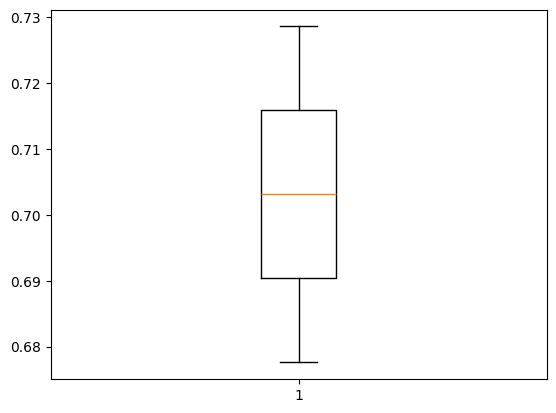

In [2]:
%matplotlib inline

from src.sota.model import SOTAFoldCrossValidation, MultiRunSOTATrainArgs, SOTATrainArgs

cross_validation = SOTAFoldCrossValidation(data_root="data", 
    model_name="yolo11m-cls", 
    dataset_name="techniques",
    train_run_args=MultiRunSOTATrainArgs(model="yolo11m-cls", runs=1,
        train_args=SOTATrainArgs(epochs=1, balanced=False)))

cross_validation.train_folds()

Average Top 1 accuracy: 0.7085610270500183


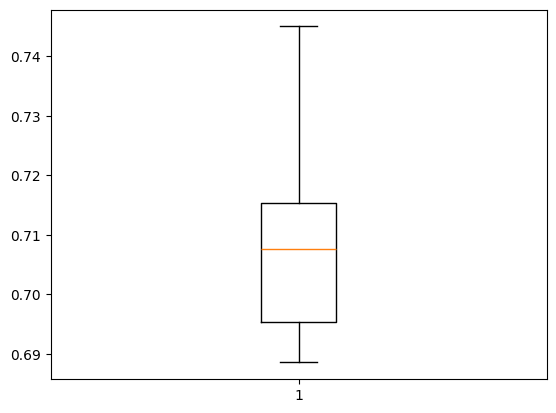

In [4]:

cross_validation = SOTAFoldCrossValidation(data_root="data", 
    model_name="yolo11n-cls", 
    dataset_name="techniques",
    train_run_args=MultiRunSOTATrainArgs(model="yolo11n-cls", runs=1, 
        train_args=SOTATrainArgs(epochs=1, balanced=False)))

cross_validation.print_box_plot()

## Sota model training 

In [ ]:
from src.sota.model import SOTA

sota = SOTA("data", "yolo11m-cls")
sota.execute_train_runs(model="yolo11m-cls", runs=3, epochs=10, balanced=False)
#sota.train_model(optimizer="AdamW", lr0=0.0005)

#metrics = model.val(data="data/img/techniques/val")

In [ ]:
from src.sota.model import SOTA

sota = SOTA("data", "yolo11n-cls")
sota.execute_train_runs(model="yolo11n-cls", runs=5, epochs=10, balanced=False)

In [ ]:
from src.sota.model import SOTA

sota = SOTA("data", "yolo11m-cls-balanced")
sota.execute_train_runs(model="yolo11m-cls", runs=5, epochs=10, balanced=True)

In [ ]:
from src.sota.model import SOTA

sota = SOTA("data", "yolo11n-cls-full-balanced")
sota.execute_train_runs(model="yolo11n-cls", runs=2, epochs=5, balanced=True)

In [ ]:
from src.sota.model import SOTA

sota = SOTA("data", "yolo11m-balance-50-155", dataset_name="techniques_balanced")
sota.initialize_model("yolo11m-cls")
sota.train_model()

In [ ]:
from src.sota.model import SOTA

sota = SOTA("data", "yolo11n-balance-50-155", dataset_name="techniques_balanced")
sota.initialize_model("yolo11n-cls")
#sota.train_model()
sota.test_model()

# Sota model testing

In [ ]:
from src.sota.model import SOTA

sota = SOTA("data", "yolo11m-cls")
metrics = sota.test_model(write_to_wandb=False)

print(metrics)

In [ ]:
metrics.top1

## HPE DNN model training

In [ ]:
from src.hpe_dnn.model import HpeDnn

hpednn = HpeDnn("data", "arch1")
hpednn.execute_train_runs(runs=5, epochs=10, augment=True)

In [ ]:
from src.hpe_dnn.model import HpeDnn

hpednn = HpeDnn("data", "arch1-balanced")
hpednn.execute_train_runs(runs=5, epochs=10, augment=True, balanced=True)

In [ ]:
%load_ext tensorboard

from src.hpe_dnn.model import HpeDnn

hpednn = HpeDnn("data", "arch1_balanced", "techniques_balanced")
hpednn.initialize_model()
hpednn.train_model()

In [ ]:
from os.path import join
run_dir = join("data", "sota", "yolo11n-cls-full-balanced")
run_dir

In [ ]:
from src.hpe_dnn.model import HpeDnn

hpednn = HpeDnn("data", "arch1_balanced_augmented", "techniques_balanced")
hpednn.initialize_model()
hpednn.train_model(augment=True)

In [ ]:
from src.hpe_dnn.model import HpeDnn, DnnArch

hpednn = HpeDnn("data", "arch2_balanced", "techniques_balanced")
hpednn.initialize_model(DnnArch.ARCH2)
hpednn.train_model()

In [ ]:
from src.hpe_dnn.model import HpeDnn, DnnArch

hpednn = HpeDnn("data", "arch3_balanced", "techniques_balanced")
hpednn.initialize_model(DnnArch.ARCH3)
hpednn.train_model()

In [ ]:
from src.hpe_dnn.model import HpeDnn

hpednn = HpeDnn("data", "arch1_full_balanced")
hpednn.execute_train_runs(runs=2, epochs=10, augment=True, balanced=True)

In [ ]:
from src.hpe_dnn.model import HpeDnn, DnnArch

hpednn = HpeDnn("data", "arch1_balanced_not_norm", "techniques_balanced")
hpednn.initialize_model(DnnArch.ARCH1, normalize=False)
hpednn.train_model()

In [ ]:
from src.hpe_dnn.model import HpeDnn, DnnArch

hpednn = HpeDnn("data", "arch1_balanced_dr_0.3", "techniques_balanced")
hpednn.initialize_model(DnnArch.ARCH1, dropout_rate=0.3)
hpednn.train_model()

In [ ]:
%tensorboard --logdir data/runs/hpe_dnn/arch1_balanced/train1/logs/train

In [ ]:
from src.hpe_dnn.model import read_data

df_path = "data/df/techniques/train.pkl"
train = read_data(df_path)